In [6]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.layers import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
(xtrain,ytrain),(xtest,ytest)= tf.keras.datasets.mnist.load_data()

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

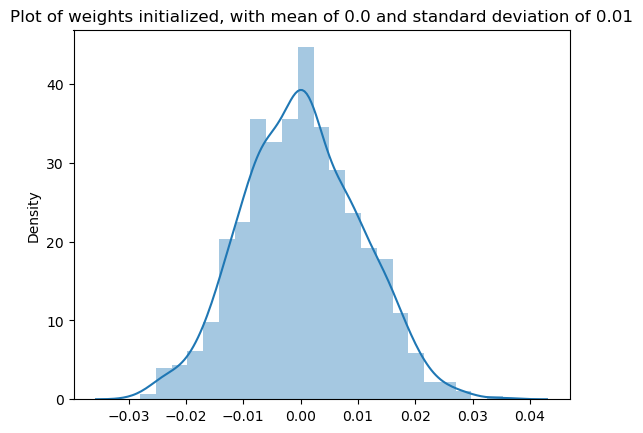

In [3]:
def initialize_weights(shape, name=None,dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

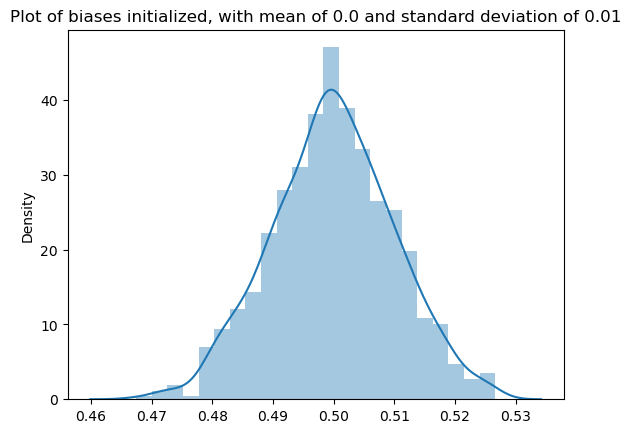

In [4]:
def initialize_bias(shape, name=None,dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)


# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [5]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [25]:
xtrain.shape[0]

60000

In [26]:
def image_scaler(scaling_array,scale_factor=4):
    upscaled_images = np.empty((scaling_array.shape[0],112,112))
    for i, image in enumerate(scaling_array):
        upscaled_images[i] = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    return upscaled_images

In [27]:
xtrain.shape

(60000, 28, 28)

In [28]:
ups_xtrain = image_scaler(xtrain)

In [29]:
ups_xtrain.shape

(60000, 112, 112)

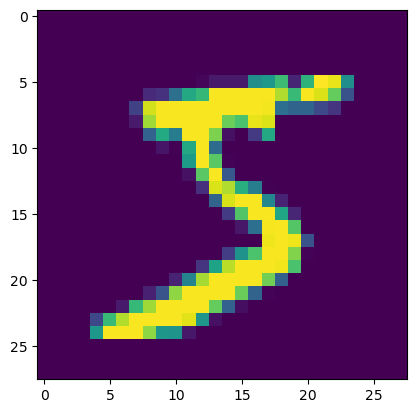

In [30]:
plt.imshow(xtrain[0])

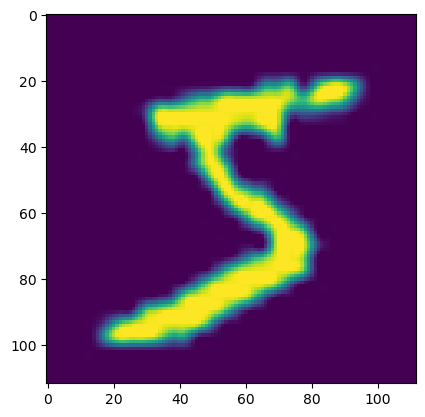

In [31]:
plt.imshow(ups_xtrain[0])

In [32]:
model = get_siamese_model((112,112, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 4096)         38947648    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [33]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)